In [0]:
!wget https://raw.githubusercontent.com/AJV009/Machine_Learning_NB/master/datasets/doctor_data/doctor_train.csv
!wget https://raw.githubusercontent.com/AJV009/Machine_Learning_NB/master/datasets/doctor_data/doctor_test.csv
from IPython import display
display.clear_output()
from fastai.tabular import *
# import pandas as pd, numpy as np, matplotlib.pyplot as plt
df = pd.read_csv('doctor_train.csv')
test_df = pd.read_csv('doctor_test.csv')

cols = ['age','Money','day','Time','Doctor_visits','last_visit',
        'cured_in','Profession','Status','edu','Irregular','residence',
        'prev_diagnosed','communication','Month','side_effects']
dep_var = ['Y']

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le_y = le.fit(df['Y'])
df['Y'] = le_y.transform(df['Y'])

In [0]:
df_D = pd.get_dummies(df[cols])
test_df_D = pd.get_dummies(test_df[cols])
cols = df_D.columns.values
for i in cols:
  df_D[i+'_c'] = df_D[i]
  test_df_D[i+'_c'] = test_df_D[i]

cols = df_D.columns.values
cat_col = []
num_col = []
for i in cols:
  if i[-2:] == '_c':
    cat_col.append(i)
  else:
    num_col.append(i)

procs = [FillMissing, Categorify, Normalize]

In [5]:
df_D['Y'] = df['Y']

data = (TabularList.from_df(df_D, procs=procs, cont_names=num_col, cat_names=cat_col)
          .split_by_idx(valid_idx=range(int(len(df_D)*0.9),len(df_D)))
          .label_from_df(cols=dep_var)
          .add_test(TabularList.from_df(test_df_D, cont_names=num_col, cat_names=cat_col, procs=procs))
          .databunch())

learn = tabular_learner(data, layers=[300, 500, 800, 1000, 3000, 4000, 3000, 2000, 1000, 100, 50, 30], metrics=accuracy)
learn.fit_one_cycle(15)

epoch,train_loss,valid_loss,accuracy,time
0,0.417233,0.363331,0.899291,00:18
1,0.254705,0.296255,0.892908,00:19
2,0.228097,0.235274,0.901418,00:19
3,0.211785,0.294761,0.879078,00:18
4,0.170371,0.225770,0.899645,00:18
5,0.131298,0.460830,0.870567,00:19
6,0.090621,0.340413,0.897163,00:19
7,0.065992,0.601986,0.891135,00:19
8,0.048723,0.458818,0.897872,00:19
9,0.025544,0.566264,0.886525,00:19


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.00E-06
Min loss divided by 10: 3.63E-08


epoch,train_loss,valid_loss,accuracy,time
0,0.064663,0.332622,0.892908,00:12
1,0.063537,0.324225,0.889716,00:12
2,0.064113,0.325988,0.891489,00:12
3,0.061733,0.334014,0.895390,00:12


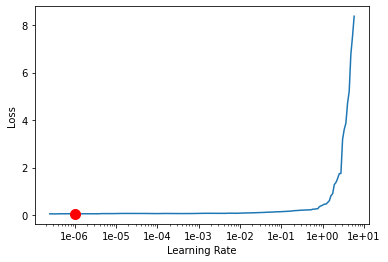

In [4]:
learn.lr_find(stop_div=False, num_it=200)
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr
learn.fit_one_cycle(4, min_grad_lr)

In [6]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)
pred_prob, pred_class = preds.max(1)

le_y = le.inverse_transform(pred_class)

output = pd.DataFrame({'id': test_df.ID,
                       'Y': le_y})
output.to_csv('submission.csv', index=False)
from google.colab import files
files.download('submission.csv')